Временные ряды - финальный проект
====

Основное задание
---

В данном проекте главной задачей будет построить алгоритм, определяющий поиски аномалий.

Можно так же сделать симуляцию своей системы, то есть проверить, как система работала бы в продакшине, какие данные она бы использовала для перетренировки и как часто эта перетренировка бы соврешалась.

**На выбор** у вас два датасета. Один имеет много данных, а второй  временной ряд наоборот, содержат в себе еще очень мало информации. Вы так же можете использовать и другие датасеты из тех, что у вас есть в доступе на гитхабе. Но тогда вам прийдется сформулировать и ту задачу, которую вы пытаетесь решить, а именно пояснить, зачем в данном случае нам нужен поиск аномалий и как это будет применено на практике. 


Датасеты
------

Пассажиропоток нью-йоркского такси
--


In [1]:
import pandas as pd
df = pd.read_csv('../datatest/nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Данные за период с Июля, 2014 года по Январь, 2015. Агрегированы с интервалом в 30 минут.

Задание:
----

* Агрегировать данные по 1 часу
* Построить алгоритм определения аномалий с задержкой в 24 часа


Общие рекомендации
------
* Старайтесь описывать свои шаги, чтобы ход ваших мыслей был понятным
* Выбор модели остается за вами
* Опишите плюсы и минусы вашей модели
* Опишите дальнейшие действия - как бы вы дальше улучшили проект, какие данные еще бы использовали

Критерии оценки
-----
* Отсутсвтие ошибок в коде и багов
* Обоснованный выбор модели
* Четкое описание действий, хороший отчет
* Приветствуются техники кросс-валидации и симуляции системы

In [2]:
# * конвертируем столбец в формат даты и устанавливаем его как индекс
# агрегируем данные по 1 часу

In [3]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [4]:
df.set_index('timestamp',inplace=True)

In [5]:
df=df.resample('H').sum()

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)

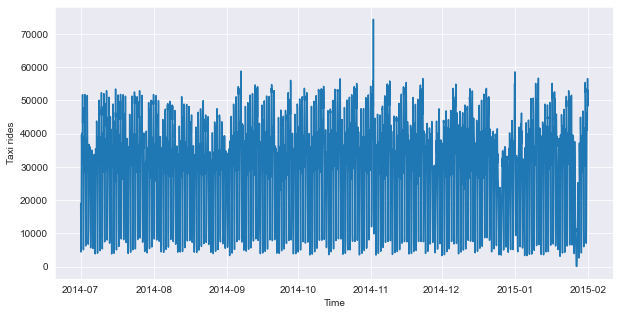

In [7]:
fig, ax = plt.subplots()

ax.plot(df.index, df.value);
ax.set_xlabel("Time");
ax.set_ylabel("Taxi rides");

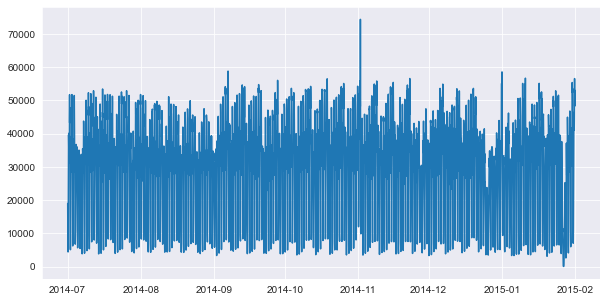

In [8]:
# сделаем график по году
fig, ax = plt.subplots()


oneyear = df['2014-07-01':'2015-07-01'];
ax.plot(oneyear.index, oneyear['value']);

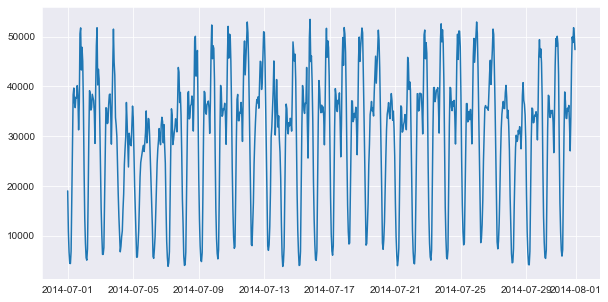

In [9]:
# сделаем график по месяцу
fig, ax = plt.subplots()


onemonth = df['2014-07-01':'2014-07-31'];
ax.plot(onemonth.index, onemonth['value']);

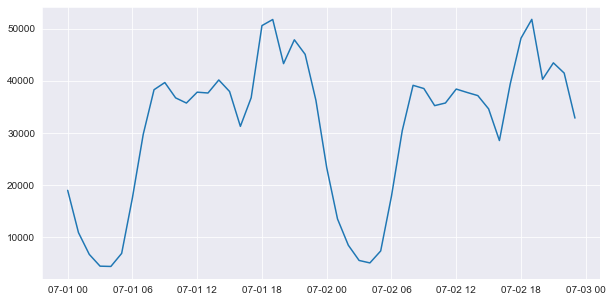

In [10]:
# сделаем график за сутки
fig, ax = plt.subplots()

oneday = df['2014-07-01':'2014-07-02'];
ax.plot(oneday.index, oneday['value']);

In [11]:
# визуальный анализ показывает ярко выраженный суточный цикл, менее выраженный недельный и менее выраженный годовой. Будем применять библиотеку Prophet, в котором есть ряды Фурье, можно использовать несколько сезонностей

In [12]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import numpy as np
import seaborn as sns
sns.set()
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
import itertools
import matplotlib.dates as mdates

In [13]:
df.index.names = ['ds']
df.rename(columns = {'value': 'y'}, inplace=True)
df['ds'] = df.index

In [14]:
df2 = df.copy()

In [15]:
# отрезаем последние әң часа, чтобы делать

In [16]:
df = df[:-24]

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
df.head()

,y,ds
ds,,
2014-07-01 00:00:00,18971,2014-07-01 00:00:00
2014-07-01 01:00:00,10866,2014-07-01 01:00:00
2014-07-01 02:00:00,6693,2014-07-01 02:00:00
2014-07-01 03:00:00,4433,2014-07-01 03:00:00
2014-07-01 04:00:00,4379,2014-07-01 04:00:00


In [19]:
m = Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)

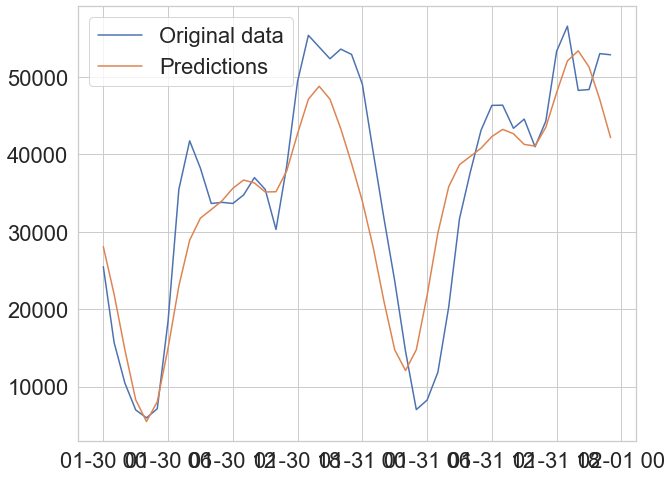

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(df2['ds'][-48:], df2['y'][-48:], label = 'Original data')
plt.plot(forecast['ds'][-48:], forecast['yhat'][-48:], label = 'Predictions')
ax.legend()
plt.show()

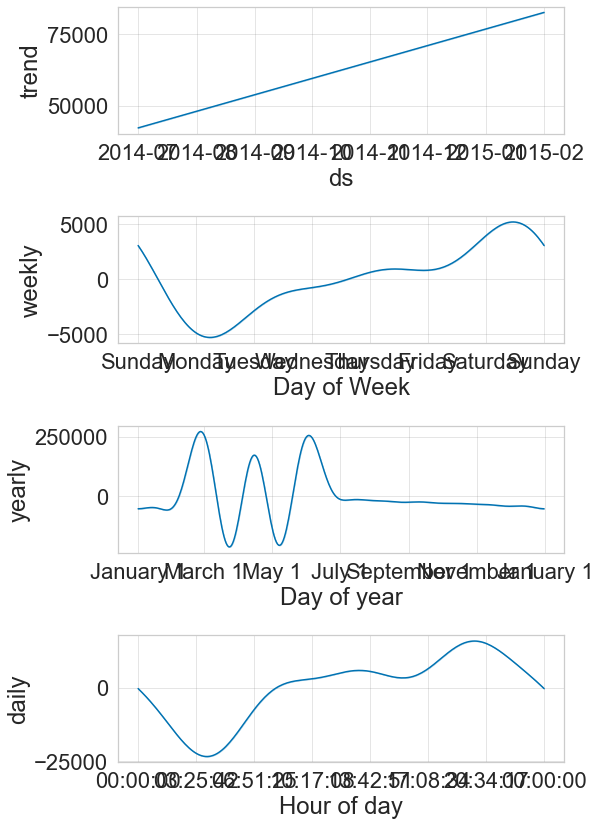

In [21]:
fig = m.plot_components(forecast)

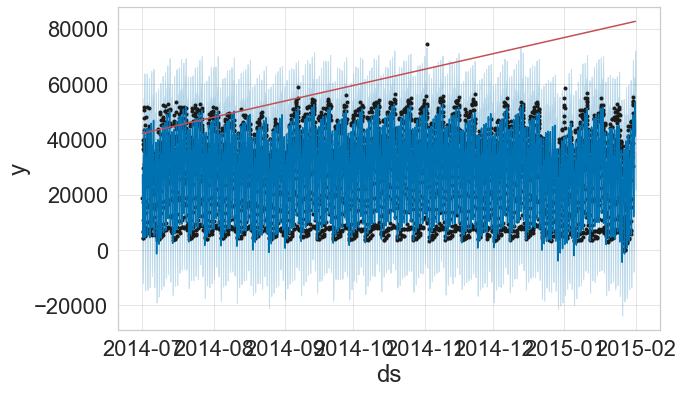

In [22]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [23]:
forecast['fact'] = df['y'].reset_index(drop = True)

In [24]:
# Создадим индикатор, показывающий аномалии
forecast['anomaly'] = forecast.apply(lambda rows: 'Anomaly' if ((rows.fact<rows.yhat_lower)|(rows.fact>rows.yhat_upper)) else 'Not anomaly', axis = 1)

In [25]:
# Определим общее количество аномалий
forecast['anomaly'].value_counts()

Not anomaly    5086
Anomaly          74
Name: anomaly, dtype: int64

<AxesSubplot:xlabel='ds', ylabel='fact'>

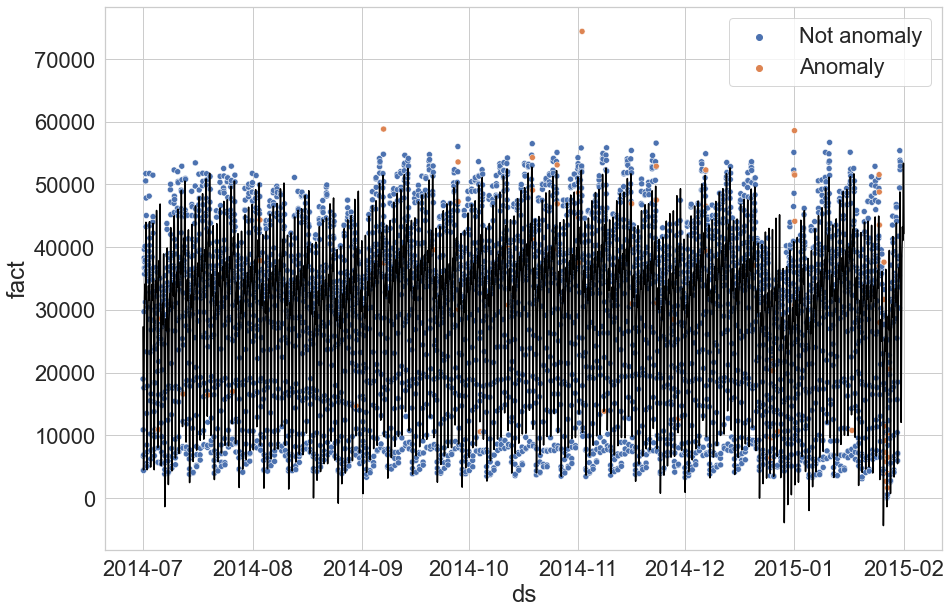

In [26]:
sns.scatterplot(x='ds', y='fact', data=forecast, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=forecast, color='black')

In [27]:
# сделаем кросс-валидацию

In [28]:

df_cv = cross_validation(m,  initial='90 days', horizon = '30 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2014-10-02 23:00:00 and 2014-12-31 23:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']

In [30]:
df_cv1 = df_cv[df_cv['cutoff']==df_cv['cutoff'].unique()[0]]

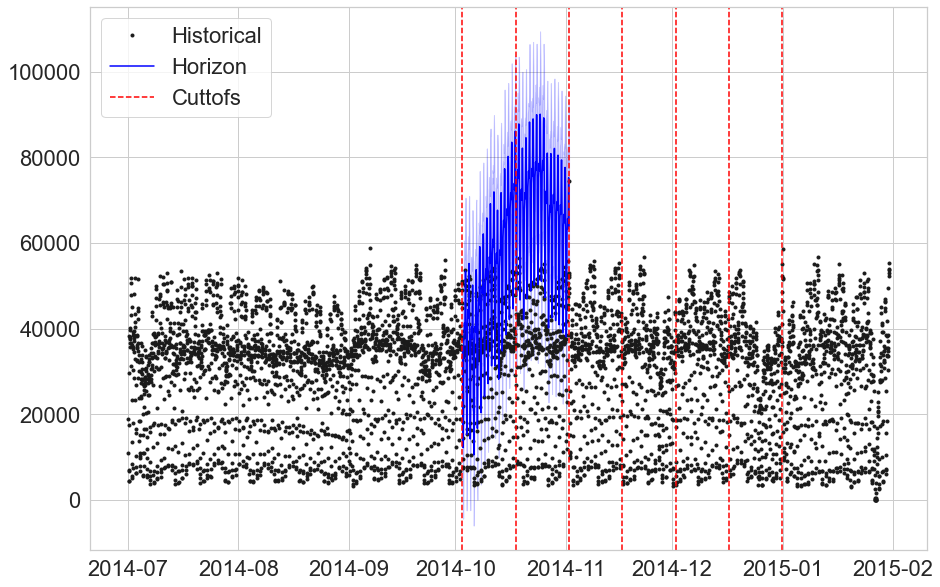

In [31]:
fig, ax = plt.subplots()

ax.plot(m.history['ds'], m.history['y'], 'k.', label = 'Historical')
ax.plot(df_cv1['ds'], df_cv1['yhat'], ls = '-', label = 'Horizon', color='blue')
ax.fill_between(df_cv1['ds'],
                df_cv1['yhat_lower'],
                df_cv1['yhat_upper'],
                color = 'blue',
                alpha = 0.2)
for i in range(len(cutoffs)):
    plt_dict = {'x': cutoffs[i],
                'c': 'red',
                'ls':'--'
                }
    if i == 0:
        plt_dict['label'] = 'Cuttofs'
    ax.axvline(**plt_dict)
ax.legend()
plt.show()

In [32]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days 00:00:00,1.165618e+08,10796.381045,8596.361247,0.451556,0.233149,0.332348,0.906746
1,3 days 01:00:00,1.184886e+08,10885.246187,8662.693767,0.455539,0.235175,0.334565,0.900794
2,3 days 02:00:00,1.159628e+08,10768.601307,8627.952543,0.461155,0.234177,0.335369,0.896825
3,3 days 03:00:00,1.163971e+08,10788.746895,8668.173922,0.471662,0.235175,0.338366,0.892857
4,3 days 04:00:00,1.163018e+08,10784.332755,8702.326797,0.485899,0.234177,0.342086,0.890873


In [33]:
df_p.mean()

horizon      16 days 12:00:00
mse         8083298099.036906
rmse             78509.430057
mae              60911.516631
mape                10.675552
mdape                1.547861
smape                0.989914
coverage             0.265619
dtype: object

In [34]:
# сделаем подбор параметров, чтобы подобрать наилучшую модель

In [35]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p2 = performance_metrics(df_cv2, rolling_window=1)
    rmses.append(df_p2['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001FC20982760>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001FC2156A310>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001FC22943FD0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001FC2156A5E0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Applying 

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  8422.401258
1                     0.001                     0.10  8368.403840
2                     0.001                     1.00  8367.662238
3                     0.001                    10.00  8398.250835
4                     0.010                     0.01  8211.070261
5                     0.010                     0.10  8155.362130
6                     0.010                     1.00  8159.119243
7                     0.010                    10.00  8158.450426
8                     0.100                     0.01  8358.561856
9                     0.100                     0.10  8295.923246
10                    0.100                     1.00  8291.909104
11                    0.100                    10.00  8306.517770
12                    0.500                     0.01  8546.302074
13                    0.500                     0.10  8479.533926
14        

In [36]:
best_params = all_params[np.argmin(rmses)]
best_params

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}

In [38]:
m = Prophet(**best_params).fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [39]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model